#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.39748186,  0.87170664, -0.28659328],
       [-0.86999317,  0.45730719,  0.18434212],
       [ 0.29175342,  0.17606155,  0.94015013]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002788


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000269


In [37]:
C1(dx,dy,dz,Ret)

array([[-1.21091177e+00,  2.55499183e-01, -7.43750495e-01,
        -1.08213742e+00,  7.69441300e-03,  3.08340713e-01,
        -1.86006721e+00, -4.41296333e-02, -1.19420701e-01,
        -2.55335150e+00,  4.87392945e-01,  8.99842982e-01,
         3.63368515e-01,  1.45991464e-02, -2.46539014e-01,
         2.70461404e+00,  1.37176175e-03, -2.69742930e-01,
        -2.39697400e-02,  1.73616880e-01, -4.76146129e-01,
        -2.47005362e+00,  1.43303524e-01,  1.24879824e-03,
        -2.58233964e+00, -1.26003957e+00,  2.93621418e+00,
        -6.68229030e-01,  1.13576797e-01,  1.08329707e+00,
         9.89308211e-02, -2.37237436e+00, -9.74852152e-01,
         2.07411101e+00, -1.63271498e-01,  8.96177312e-01,
         1.40132086e-01,  2.17788921e+00, -3.85751253e-04,
        -3.03707123e+00,  5.70346440e-02, -2.00003281e-01,
         1.63635548e+00, -3.52369063e+00,  3.58989921e-01,
         3.39469887e-01,  2.50993218e-01, -4.22042142e-01,
        -2.33181620e-01,  2.46352547e-02],
       [-4.46

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-6.94946372e+03, -2.56308530e+03,  1.67426963e+04],
       [ 1.46631848e+03,  7.05053478e+02, -2.10324388e+03],
       [-4.26840933e+03, -4.78275274e+04,  1.77470625e+04],
       [-6.21042336e+03,  8.07313120e+02, -1.67811625e+03],
       [ 4.41584973e+01, -4.48749202e+03, -6.57819766e+03],
       [ 1.76957782e+03, -2.71630522e+03,  8.15631622e+03],
       [-1.06749888e+04,  1.98608982e+04,  2.21898899e+04],
       [-2.53261463e+02, -1.48877668e+04, -7.25202995e+03],
       [-6.85359453e+02, -9.77559280e+03,  1.43193202e+04],
       [-1.46537709e+04, -3.21939165e+03, -2.79775417e+03],
       [ 2.79716465e+03,  3.27661854e+03,  1.54772200e+03],
       [ 5.16422941e+03, -2.24060733e+04,  2.13216935e+04],
       [ 2.08538424e+03, -1.39058095e+03,  2.70399427e+03],
       [ 8.37849967e+01,  2.02742828e+04,  3.85186978e+03],
       [-1.41489577e+03,  4.74000624e+02,  3.96367123e+02],
       [ 1.55218718e+04,  7.71514974e+03,  5.27325179e+02],
       [ 7.87258724e+00,  1.13670548e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000242


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000376


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000028


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-1.00552674e+00, -1.52081303e+00, -8.36683506e-01],
       [-2.12329485e-01,  6.71539787e-01,  2.96448246e-01],
       [-3.97492830e-01, -6.58161621e-01,  8.46534318e-01],
       [-1.09461105e+00,  2.25255488e-01, -5.78723697e-01],
       [-1.80516796e+00,  2.58366822e-01, -1.18248611e-01],
       [ 1.56569080e+00,  2.32302368e+00, -1.43181851e-01],
       [ 1.46057171e+00, -9.46742269e-02,  1.70627608e-01],
       [ 3.54495620e-01,  2.02961657e-01,  7.23062078e-01],
       [-9.07221758e-01,  6.68304886e-01, -9.56632309e-01],
       [ 9.07351186e-01,  9.18437911e-01,  1.02364629e+00],
       [-6.38006328e-01, -1.58282499e-01,  2.20270830e-01],
       [ 1.55275303e-01, -1.11076154e+00,  4.89373964e-01],
       [-2.31023814e-02,  1.03703157e+00, -1.38654560e-01],
       [ 5.87358687e-02, -7.36009668e-01,  1.29705590e+00],
       [ 1.33703037e+00,  1.28909503e+00, -2.15033160e+00],
       [ 4.72434299e-01, -4.47397748e-01,  4.59451362e-01],
       [-1.75733565e-01, -9.96150936e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000202


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000504


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000705


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-4.84031303e-01, -8.16680150e-01,  4.38342727e-01],
       [ 1.34136755e-01, -4.96240353e-01, -1.07585828e+00],
       [ 2.67723315e-01,  8.89209755e-01,  9.29567290e-02],
       [-1.50094675e-01, -3.64020206e-01,  1.46844940e-01],
       [ 5.97036892e-01, -8.85295507e-01, -4.31847478e-02],
       [-2.57658113e-01, -9.05942521e-01, -3.62539426e-01],
       [-8.95166782e-01, -1.24447799e+00,  2.60767447e-01],
       [ 7.18411030e-01,  1.34537558e+00,  3.11034710e-01],
       [ 6.98152537e-01, -2.27010949e+00, -1.15336739e+00],
       [-2.26186430e-01, -1.18280118e+00, -2.19793534e-02],
       [-3.22407663e-01,  1.02707030e+00, -5.50858442e-01],
       [-2.77277235e-01, -9.32796531e-01, -1.75802470e-01],
       [-1.69423292e-01,  7.27688768e-01, -2.08206457e-01],
       [ 1.94496119e+00, -1.04196520e+00, -1.09409993e+00],
       [-3.29664969e-02,  1.34818159e+00, -1.11795125e+00],
       [-1.10368816e+00,  8.31061809e-01,  4.14507598e-01],
       [-1.77589165e-01, -8.38332571e-01

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 6.07906337e-03, -3.34145812e-03,  1.35104765e-02,
        -7.22541502e-03, -3.37670407e-03, -2.20789169e-02,
         2.38322546e-03,  4.69234551e-03, -1.45923196e-02,
         9.94905845e-04,  3.39936326e-03,  1.43460089e-02,
        -1.05290992e-02,  1.82626270e-02, -3.08934008e-02,
         8.13984098e-03,  1.30275495e-02, -5.35648782e-03,
        -1.70837473e-02,  5.57757377e-03,  2.49952587e-02,
        -3.03337659e-04, -1.06649471e-02,  2.58303776e-03,
        -4.42726733e-03, -6.20812331e-03,  2.61058071e-02,
         8.45187762e-03,  1.51715557e-02, -2.10270293e-02,
        -2.17122483e-02, -1.93762829e-02,  4.31646349e-04,
        -1.70094292e-04, -1.51690061e-02, -1.11831514e-02,
         1.95069618e-03,  5.36366755e-03,  2.02676762e-03,
        -2.04703499e-02,  1.98806689e-03, -4.07219598e-03,
        -2.28741046e-02, -8.30547752e-03, -1.45621421e-02,
        -1.44895311e-03, -3.52220578e-03, -5.50815424e-03,
        -5.38877372e-03,  7.27019626e-03],
       [ 7.47

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001382


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 2.26242861e-06, -3.61827607e-07,  1.83648542e-06,
         5.73394676e-08,  2.23768339e-07, -3.05901650e-06,
        -6.98227422e-07, -6.26908448e-07,  1.61482392e-07,
        -8.64288059e-07,  3.56676708e-07,  5.77829742e-07,
        -1.25033895e-06,  8.24618752e-07, -2.64533827e-06,
        -6.14323074e-07, -2.76434549e-08, -2.84584617e-06,
         1.32790500e-06,  3.38859690e-07, -1.26492739e-06,
        -8.27277305e-07, -2.44775451e-07,  1.20280289e-06,
        -8.34326649e-08, -4.45879600e-07, -8.84971510e-07,
         1.38917038e-06,  4.82403495e-07,  9.17552811e-07,
        -3.29460987e-06, -2.20164839e-06,  3.58942422e-07,
        -3.15886151e-08, -2.17928734e-06,  2.01845288e-08,
         5.05377486e-07, -1.02277249e-06, -1.61495510e-07,
         8.65913528e-07,  8.62913423e-07, -1.39183584e-06,
        -2.68956346e-06, -1.00139679e-06,  2.78533829e-06,
        -8.44719796e-07, -6.11698233e-07,  4.47593944e-07,
        -3.23409854e-07,  1.74081725e-06],
       [-7.56

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.94946372e+03, -1.46631848e+03,  4.26840933e+03,
         6.21042336e+03, -4.41584973e+01, -1.76957782e+03,
         1.06749888e+04,  2.53261463e+02,  6.85359453e+02,
         1.46537709e+04, -2.79716465e+03, -5.16422941e+03,
        -2.08538424e+03, -8.37849967e+01,  1.41489577e+03,
        -1.55218718e+04, -7.87258724e+00,  1.54806383e+03,
         1.37563151e+02, -9.96393169e+02,  2.73261880e+03,
         1.41757216e+04, -8.22423785e+02, -7.16689547e+00,
         1.48201348e+04,  7.23140985e+03, -1.68510328e+04,
         3.83498908e+03, -6.51821092e+02, -6.21707865e+03,
        -5.67767340e+02,  1.36151369e+04,  5.59470959e+03,
        -1.19033935e+04,  9.37020666e+02, -5.14319201e+03,
        -8.04222799e+02, -1.24989801e+04,  2.21383953e+00,
         1.74298549e+04, -3.27323758e+02,  1.14782562e+03,
        -9.39109964e+03,  2.02225801e+04, -2.06025534e+03,
        -1.94822920e+03, -1.44045860e+03,  2.42211417e+03,
         1.33823723e+03, -1.41382563e+02],
       [ 2.56

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001098


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 1.01908086e+02,  2.75001887e+06, -3.77958483e+06],
       [-4.28919781e+02,  2.51933652e+06,  1.81327767e+06],
       [ 5.21832434e+02, -2.74709658e+06, -2.52406512e+06],
       [-1.18847499e+02,  2.96988250e+06, -1.76949257e+06],
       [-4.96825065e+02,  1.60039356e+06,  3.41821380e+06],
       [-2.64693718e+02,  2.44602750e+06,  2.27657507e+05],
       [ 2.31970150e+02,  5.12824554e+05, -2.85610172e+06],
       [ 4.09012916e+02, -5.85996536e+05, -3.54562603e+06],
       [-2.17759734e+01,  2.18911778e+05,  1.04756463e+03],
       [ 8.58488480e+01,  1.14484503e+06, -2.01210692e+06],
       [-8.51630924e+01, -2.69014592e+06,  3.55055895e+06],
       [-1.11244203e+02,  2.33015631e+06, -1.20653882e+06],
       [ 1.16515585e+02, -3.65357171e+06,  2.47677231e+06],
       [-2.08470457e+02,  2.07743501e+06,  2.83282604e+04],
       [ 4.60873606e+01, -1.27661284e+05, -3.37884655e+05],
       [ 1.79414714e+02, -1.55262107e+06, -2.59661630e+05],
       [-5.74915900e+02,  3.53501812e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.61296348e+08, -3.77974451e+08, -2.75017855e+08],
       [-6.27989435e+07,  1.81321550e+08, -2.51939869e+08],
       [-2.24608196e+08, -2.52428748e+08,  2.74687423e+08],
       [-7.72007990e+08, -1.77025686e+08, -2.97064674e+08],
       [-1.71719236e+08,  3.41804380e+08, -1.60056356e+08],
       [-2.34572630e+08,  2.27425280e+07, -2.44625971e+08],
       [-7.54286312e+06, -2.85610918e+08, -5.12832021e+07],
       [-3.14685215e+06, -3.54562915e+08,  5.85993421e+07],
       [ 2.68876620e+08,  1.31375253e+05, -2.18645604e+07],
       [-5.09875516e+07, -2.01215740e+08, -1.14489550e+08],
       [-7.14512877e+07,  3.55048822e+08,  2.69007519e+08],
       [-2.06136278e+08, -1.20674289e+08, -2.33036037e+08],
       [-3.73204451e+08,  2.47640284e+08,  3.65320226e+08],
       [-2.61671659e+07,  2.83023549e+06, -2.07746091e+08],
       [-1.11690829e+07, -3.37895712e+07,  1.27650227e+07],
       [-1.95099900e+08, -2.59854779e+07,  1.55242793e+08],
       [-2.37041331e+08,  2.27209269e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000410


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001316


In [82]:
d_me_

array([[-1.64208522e-02, -1.65284389e+02,  3.31168336e+02],
       [ 6.61291545e-02, -7.18595248e+02,  5.06266683e+01],
       [-5.40128036e-02, -8.07211432e-01,  5.46418683e+02],
       [-9.83978000e-03, -1.42824124e+01,  1.13679873e+02],
       [-4.18904582e-02,  6.41560299e+01,  3.58998031e+02],
       [-4.84532398e-02,  5.93487782e+01,  4.30099599e+02],
       [-2.58798800e-02, -5.19436640e+01,  3.13372429e+02],
       [-4.08503134e-02, -6.16308108e+01,  4.74284203e+02],
       [ 7.41556289e-03,  3.37310707e+02, -4.12236260e+02],
       [-8.04988974e-02,  9.81396419e+00,  8.03346783e+02],
       [-2.54541447e-02, -2.01949466e+02,  4.59085259e+02],
       [-5.94326275e-02,  5.97420234e+01,  5.40614841e+02],
       [-3.61802420e-02, -4.17046286e+01,  4.07182191e+02],
       [ 2.43728317e-02, -1.64607089e+02, -8.15872233e+01],
       [-1.41523619e-02,  3.62819438e+01,  1.06676588e+02],
       [ 1.50215937e-02,  1.16424250e+02, -2.68171083e+02],
       [-1.48873292e-02, -1.13144643e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.94946372e+03, -1.46631848e+03,  4.26840933e+03,
         6.21042336e+03, -4.41584973e+01, -1.76957782e+03,
         1.06749888e+04,  2.53261463e+02,  6.85359453e+02,
         1.46537709e+04, -2.79716465e+03, -5.16422941e+03,
        -2.08538424e+03, -8.37849967e+01,  1.41489577e+03,
        -1.55218718e+04, -7.87258724e+00,  1.54806383e+03,
         1.37563151e+02, -9.96393169e+02,  2.73261880e+03,
         1.41757216e+04, -8.22423785e+02, -7.16689547e+00,
         1.48201348e+04,  7.23140985e+03, -1.68510328e+04,
         3.83498908e+03, -6.51821092e+02, -6.21707865e+03,
        -5.67767340e+02,  1.36151369e+04,  5.59470959e+03,
        -1.19033935e+04,  9.37020666e+02, -5.14319201e+03,
        -8.04222799e+02, -1.24989801e+04,  2.21383953e+00,
         1.74298549e+04, -3.27323758e+02,  1.14782562e+03,
        -9.39109964e+03,  2.02225801e+04, -2.06025534e+03,
        -1.94822920e+03, -1.44045860e+03,  2.42211417e+03,
         1.33823723e+03, -1.41382563e+02],
       [ 2.56

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

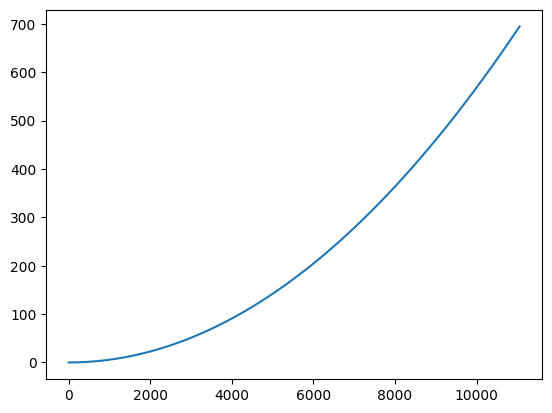

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_45040/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

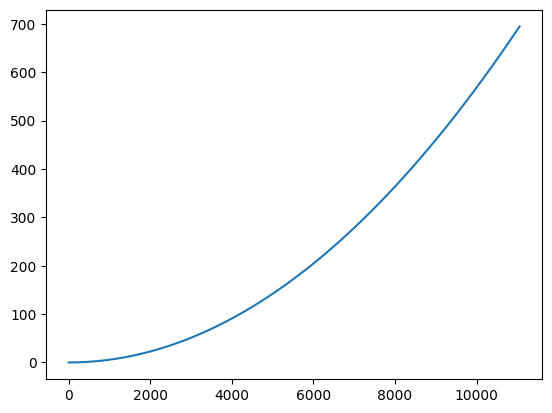

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [113]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [114]:
f

array([-1.00000000e+01, -8.37864663e-16,  2.00000000e+01,  3.94129174e-15,
        1.01675929e-15, -7.91033905e-16,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [115]:
def PipeForce(X,Y,Z,vessel_force, coef=1, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    global_force=np.zeros(len(X)*6) 
    vessel_force[0]*=-1
    vessel_force[2]*=-1
    global_force[-6:]=coef*np.array(vessel_force)
    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337],1e-10)

In [117]:
fors

array([[ 6.84355030e-06, -8.86572565e-04,  1.36430731e-02],
       [-1.11958798e-09, -1.79460566e-08, -7.60482521e-09],
       [-1.87174010e-09,  8.22594692e-09, -6.44078568e-09],
       [-3.56340024e-09, -3.09423486e-08,  1.74993176e-09],
       [-4.08908818e-09, -2.09823270e-09,  1.07695541e-08],
       [-5.12227416e-09,  6.43334985e-09, -8.66202754e-09],
       [-5.18048182e-09,  1.09499831e-08, -3.19796527e-08],
       [-5.50062396e-09, -4.15962129e-08, -7.60155672e-09],
       [-3.95812094e-09,  3.38365780e-09,  5.12955012e-10],
       [-2.32830644e-10,  7.42477368e-09, -2.61279638e-08],
       [ 3.02679837e-09,  2.07465440e-08, -1.46683306e-08],
       [ 5.12227416e-09, -4.53371288e-09, -1.85063982e-08],
       [ 6.63567334e-09,  1.13482201e-09, -7.77799869e-09],
       [ 7.91624188e-09,  2.11797158e-09,  3.52156349e-09],
       [ 9.31322575e-09,  3.24547500e-09,  6.98491931e-10],
       [ 1.28056854e-08,  3.53426251e-09,  1.95577741e-08],
       [ 1.46683306e-08, -1.06451665e-08

### Vessle Simulation

In [118]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [119]:
vehicle=semisub('DPcontrol',2,0,40.0,0,0) 

In [120]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [121]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

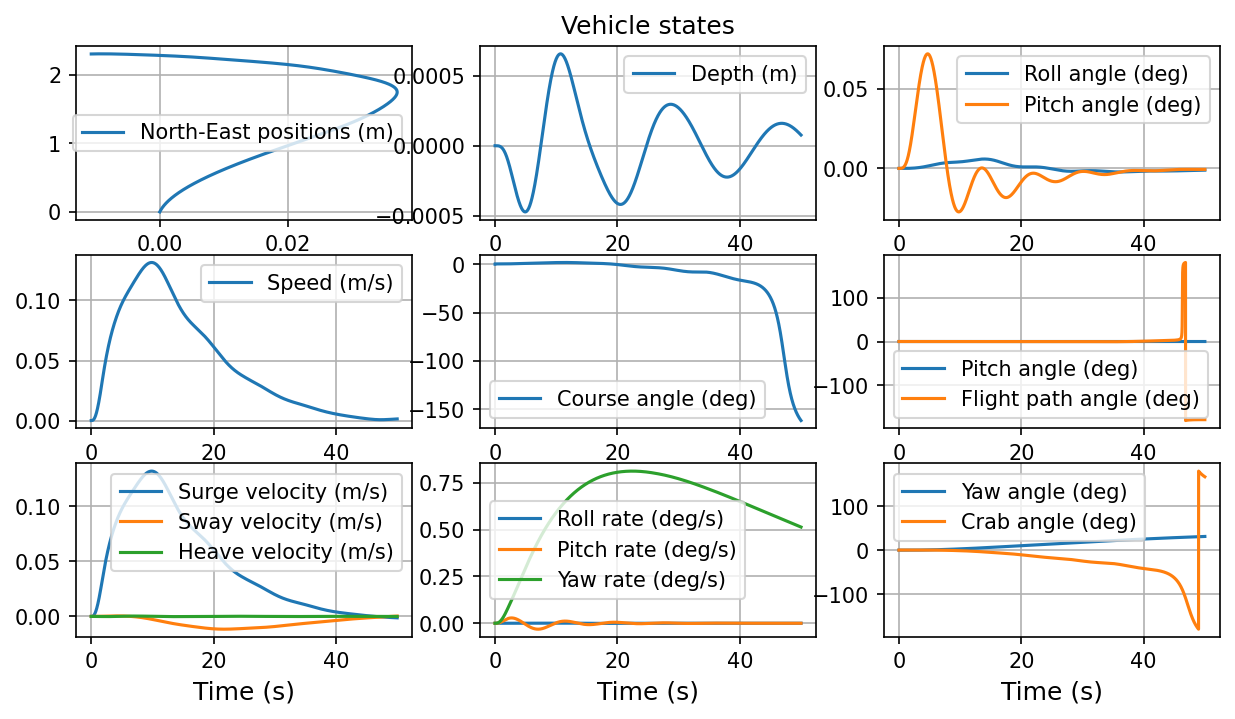

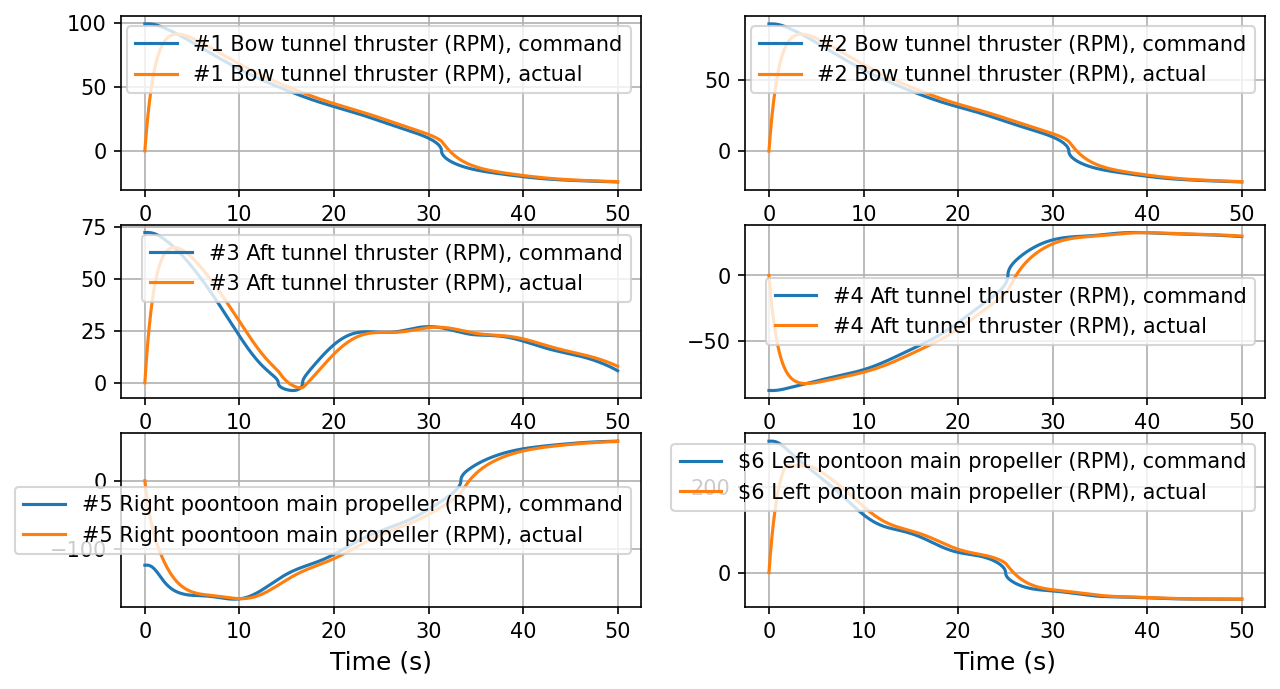

In [122]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [123]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

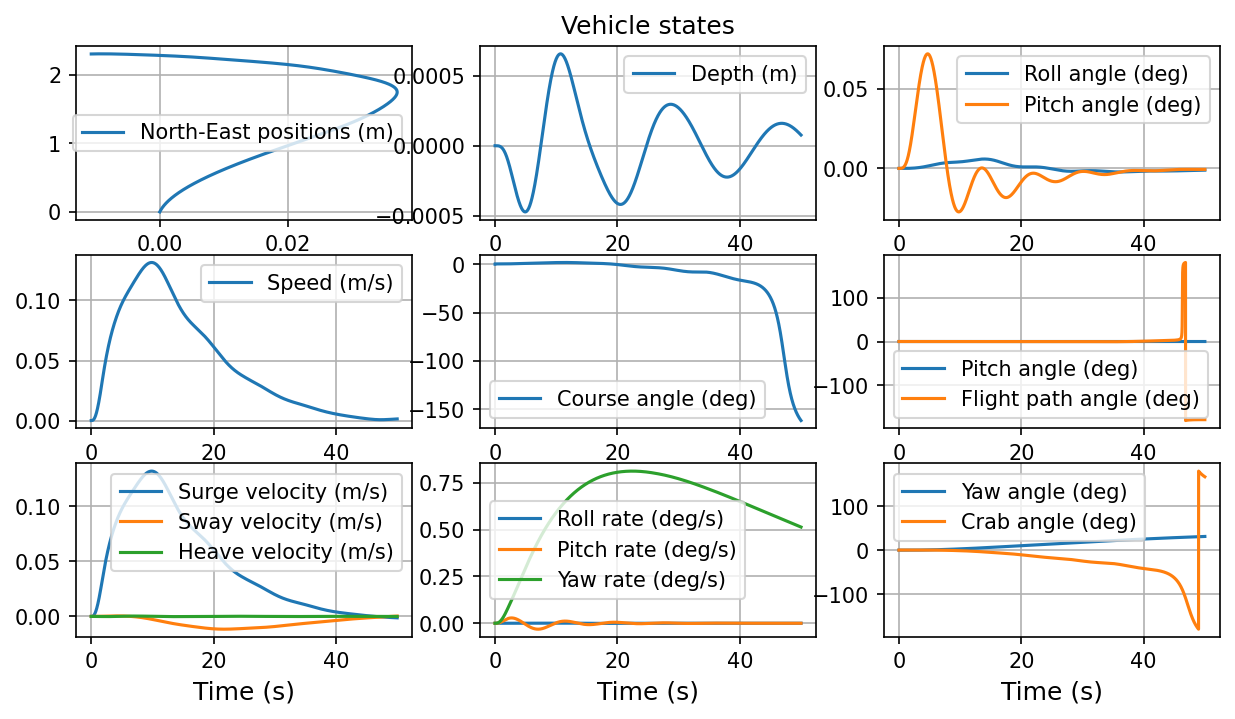

In [124]:
plotVehicleStates(simTime, simData, 3)

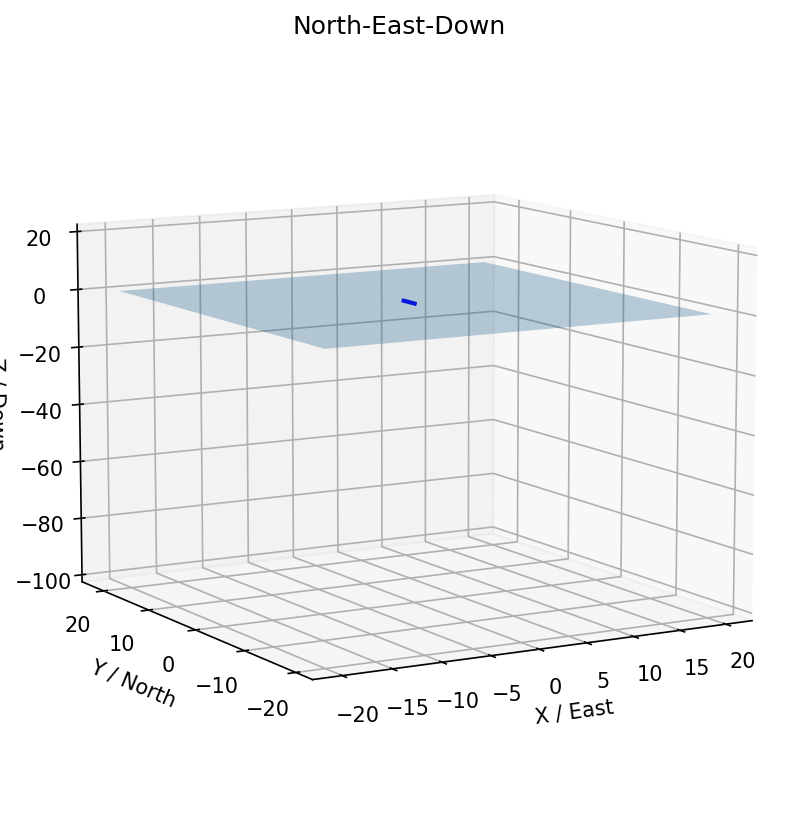

In [125]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [126]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

1.876148529866839e-07

In [131]:
ssa(simData[:, 4][int(idx)])

3.490806021000381e-05

In [132]:
ssa(simData[:, 5][int(idx)])

8.432223337440092e-05

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

### Dynamics

In [135]:
def grayscott1d(t, Q): 
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    force_schedule=(1e-11)
    
    fors, mom, angle = PipeForce(x,y,z,n_,force_schedule)
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()


    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [136]:
tspan = (0., 50)

In [137]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:04.874617


In [138]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [139]:
fin=us

In [140]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.268e-02 ...  4.834e+01  5.000e+01]
        y: [[ 0.000e+00 -1.299e-14 ... -3.858e-10 -3.854e-10]
            [ 2.256e+02  2.256e+02 ...  2.256e+02  2.256e+02]
            ...
            [ 0.000e+00 -1.744e-07 ...  1.981e-06  1.499e-06]
            [ 0.000e+00 -1.809e-07 ...  2.026e-06  1.536e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 152
     njev: 0
      nlu: 0

In [141]:
t=fin.t

In [142]:
fin=fin.y.T

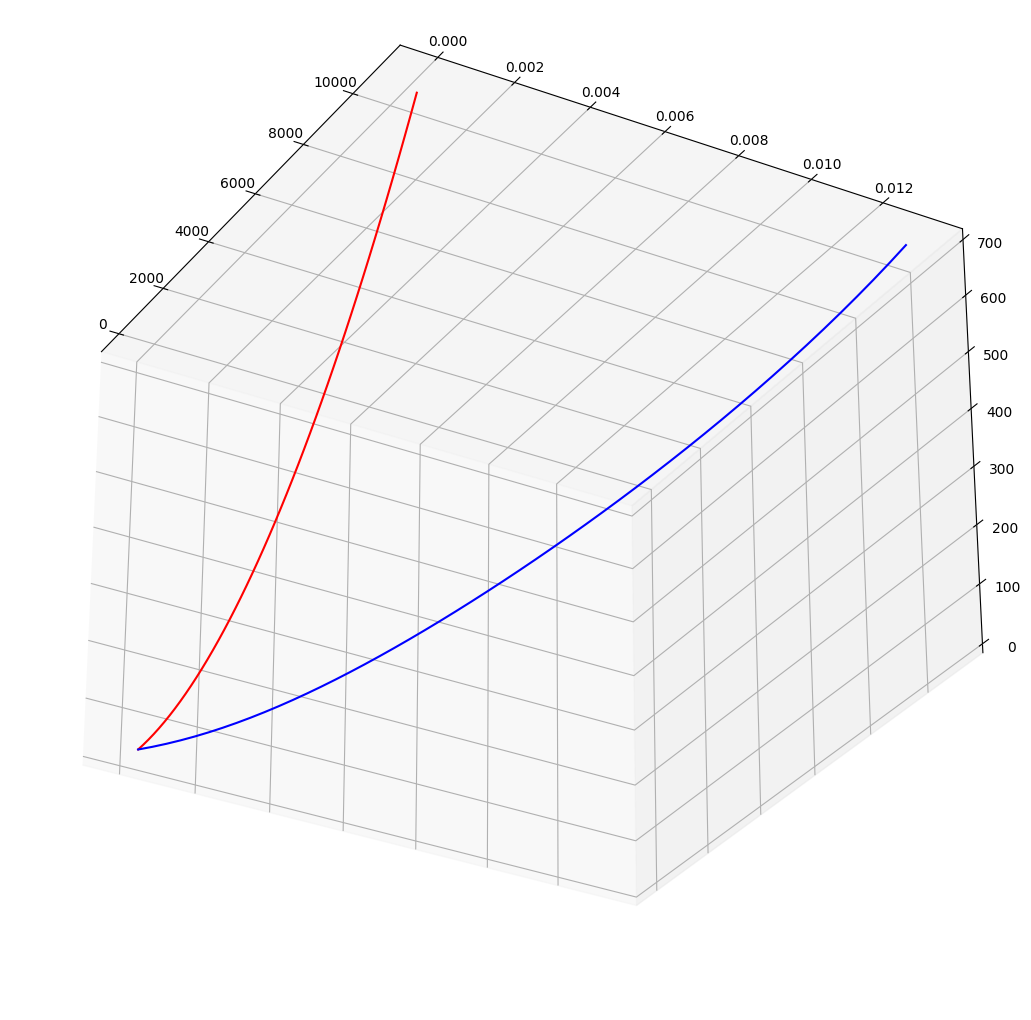

In [143]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [144]:
X,Y,Z

(array([-3.85431364e-10,  2.25564809e+02,  4.51128522e+02,  6.76690127e+02,
         9.02248699e+02,  1.12780340e+03,  1.35335347e+03,  1.57889824e+03,
         1.80443712e+03,  2.02996959e+03,  2.25549520e+03,  2.48101359e+03,
         2.70652446e+03,  2.93202757e+03,  3.15752276e+03,  3.38300993e+03,
         3.60848904e+03,  3.83396010e+03,  4.05942320e+03,  4.28487845e+03,
         4.51032604e+03,  4.73576620e+03,  4.96119920e+03,  5.18662537e+03,
         5.41204506e+03,  5.63745869e+03,  5.86286669e+03,  6.08826953e+03,
         6.31366772e+03,  6.53906180e+03,  6.76445232e+03,  6.98983989e+03,
         7.21522509e+03,  7.44060857e+03,  7.66599096e+03,  7.89137293e+03,
         8.11675515e+03,  8.34213830e+03,  8.56752306e+03,  8.79291013e+03,
         9.01830020e+03,  9.24369396e+03,  9.46909211e+03,  9.69449533e+03,
         9.91990430e+03,  1.01453197e+04,  1.03707421e+04,  1.05961723e+04,
         1.08216108e+04,  1.10470582e+04]),
 array([-1.01975098e-10,  2.39470459e-04,  4

In [145]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [146]:
us=fin.T

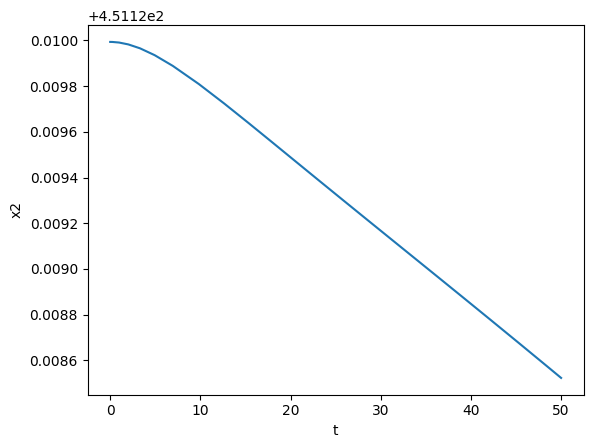

In [147]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

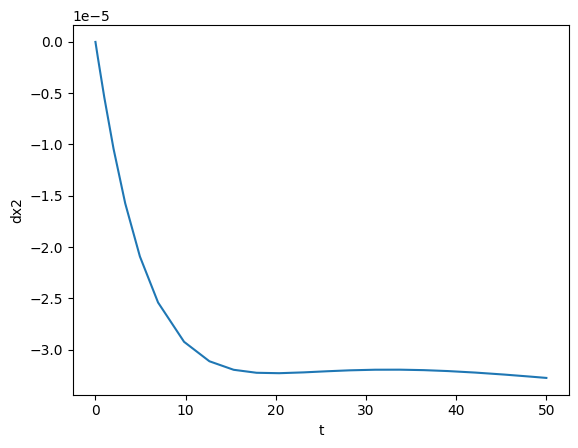

In [148]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

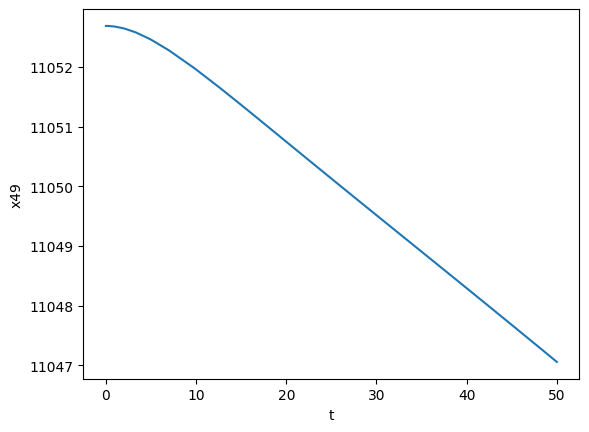

In [149]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [150]:
0.45+1.1052e4, 0.65+1.1052e4

(11052.45, 11052.65)

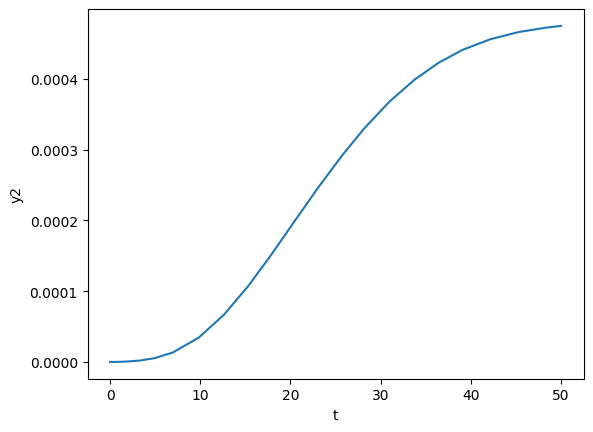

In [151]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

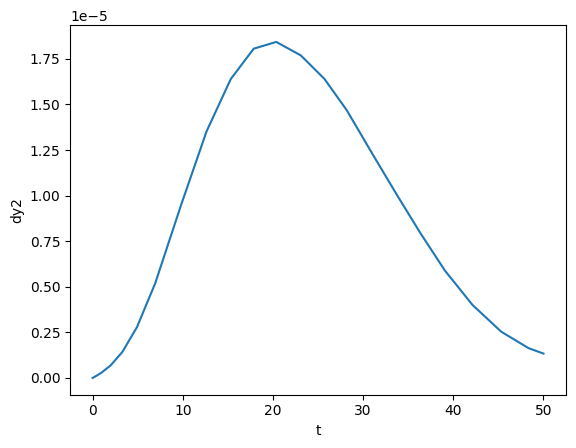

In [152]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

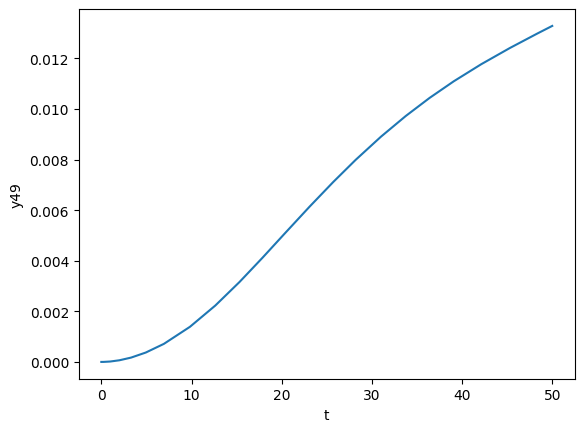

In [153]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

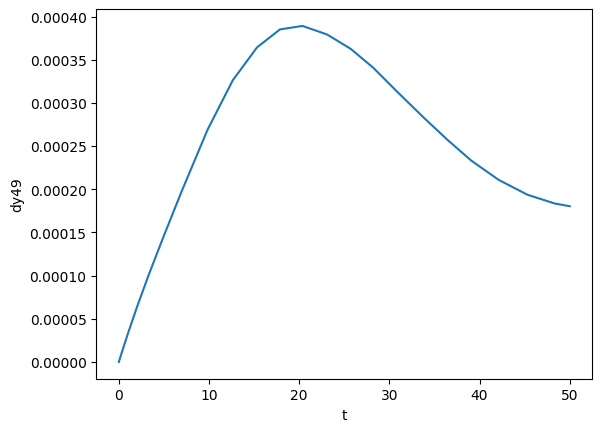

In [154]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

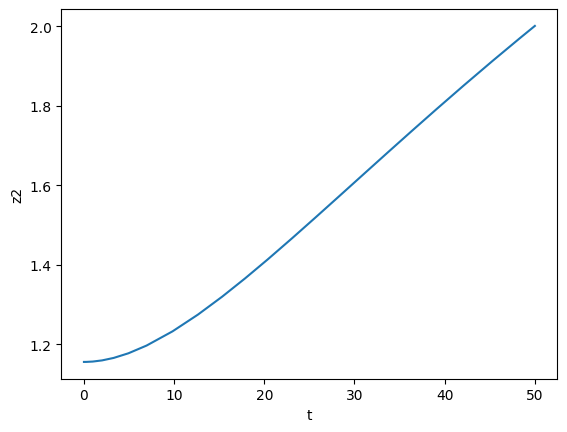

In [155]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

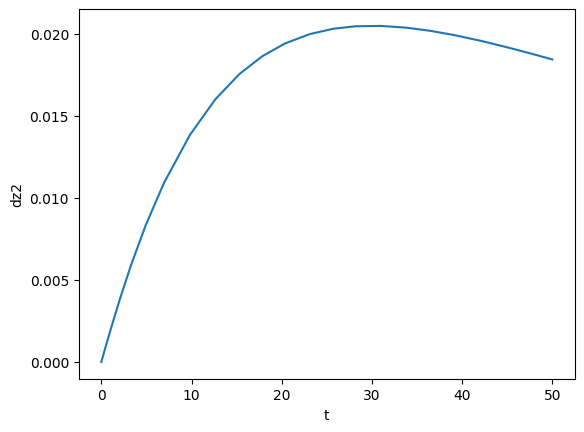

In [156]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

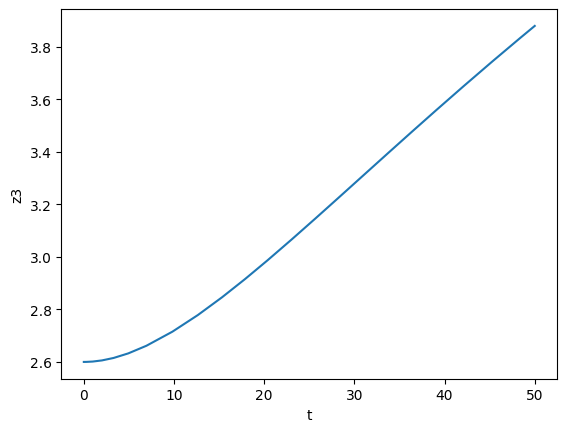

In [157]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

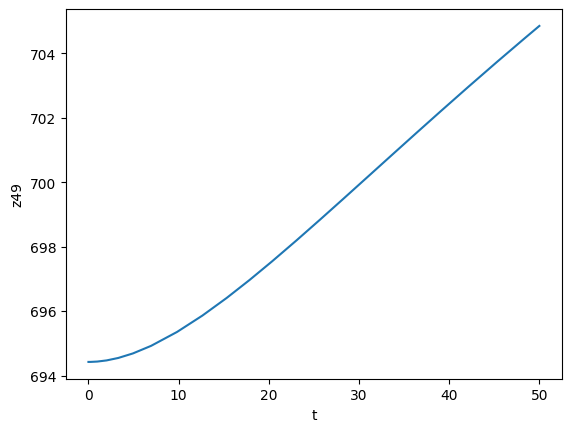

In [158]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

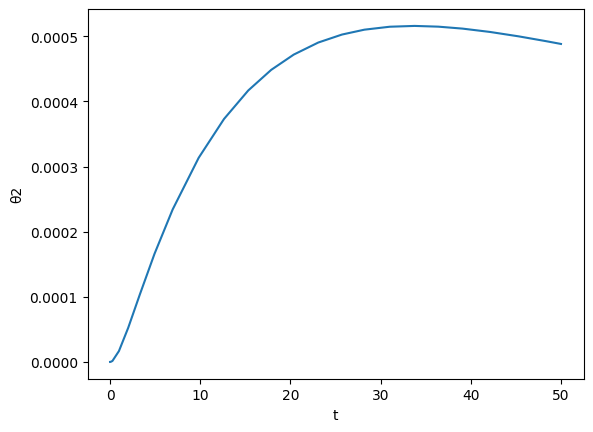

In [159]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

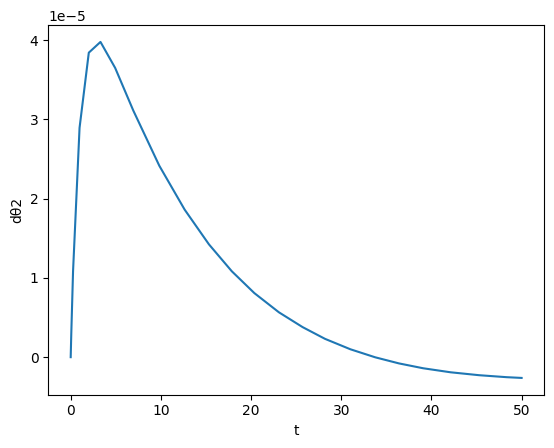

In [160]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

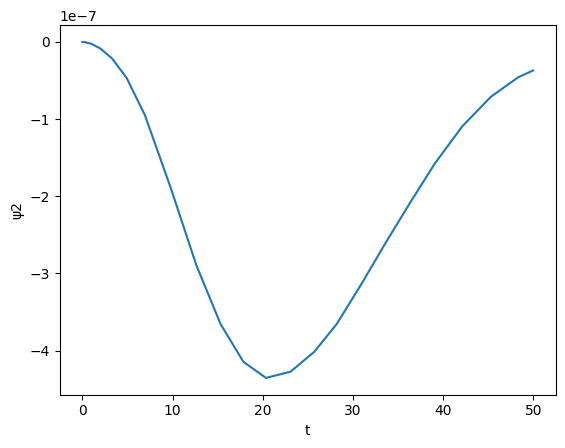

In [161]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

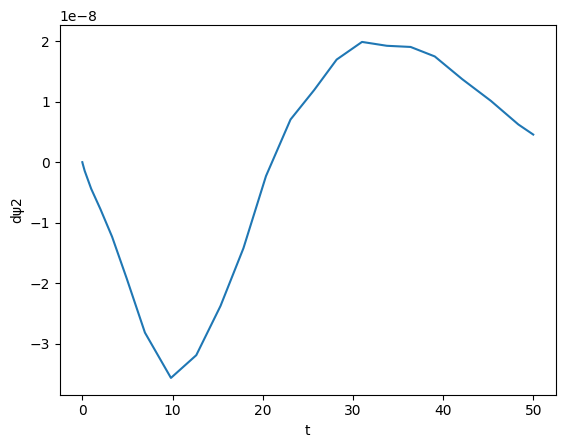

In [162]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()